In [1]:
import os
from typing import Dict

import tensorflow as tf
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras_cv.src.models.stable_diffusion.image_encoder import ImageEncoder
from diffusion_models.stable_diffusion import StableDiffusion
from utils import process_image, augmenter

from my_utils import dict_to_disk, dict_from_disk, load_image_as_tensor, resize_image_tensor, decode_masks_from_json
from visualisation_utils import plot_masks_grid
from models.dumb_experiment_probe import DumbExperimentProbe

Using TensorFlow backend


2023-12-06 16:53:33.168402: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2023-12-06 16:53:33.168429: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2023-12-06 16:53:33.168432: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
2023-12-06 16:53:33.168470: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-06 16:53:33.168486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
print(f"GPUs available: ", tf.config.experimental.list_physical_devices('GPU'))
device = tf.test.gpu_device_name()
print(tf.test.gpu_device_name())

GPUs available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


2023-12-06 16:53:33.357170: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-06 16:53:33.357186: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-06 16:53:33.357268: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-06 16:53:33.357273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Initialize SD Model

In [3]:
# Inialize Stable Diffusion Model on GPU:0
with tf.device(device):
    image_encoder = ImageEncoder()
    vae = tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-1].output,
    )
    model = StableDiffusion(img_width=512, img_height=512)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


# Run image through VAE encoder

In [4]:
image_path = "images/sa_224452.jpg"

with tf.device(device):
    image = process_image(image_path)
    image = augmenter(image)
    latent = vae(tf.expand_dims(image, axis=0), training=False)

In [5]:
# Dictionary of structure { timestep : { resolution : self-attention map } }
self_attn_dict: Dict[int, Dict[int, np.ndarray]] = { }

# Extract features for `n_timesteps`

In [6]:
n_timesteps = 10

for timestep in np.arange(0, 1000, 1000 // n_timesteps):
    with tf.device(device):
        weight_64, weight_32, weight_16, weight_8 = model.generate_image(
            batch_size=1,
            latent=latent,
            timestep=timestep,
        )

        # Average over attention heads and store self-attention maps for
        # current time step in dictionary
        self_attn_dict[timestep] = {
            8:  weight_8.mean(axis=(0,1)),
            16: weight_16.mean(axis=(0,1)),
            32: weight_32.mean(axis=(0,1)),
            64: weight_64.mean(axis=(0,1))
        }

2023-12-06 16:53:37.217626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [7]:
# Create self_attn_maps directory if it doesn't exist yet
if not os.path.exists("self_attn_maps"):
    os.makedirs("self_attn_maps")

# Save self-attention maps to disk
dict_to_disk(
    self_attn_dict=self_attn_dict,
    filename="self_attn_maps/sa_224452"
)

# Load image and its segmentation mask

torch.Size([3, 1500, 2250])

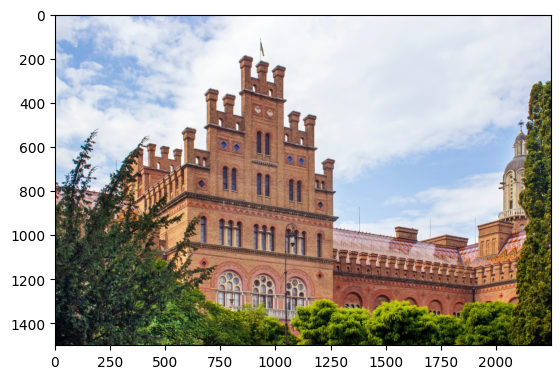

In [8]:
# Load the image as a PyTorch tensor
image_tensor = load_image_as_tensor(image_path)

plt.imshow(image_tensor.permute(1, 2, 0))
image_tensor.shape

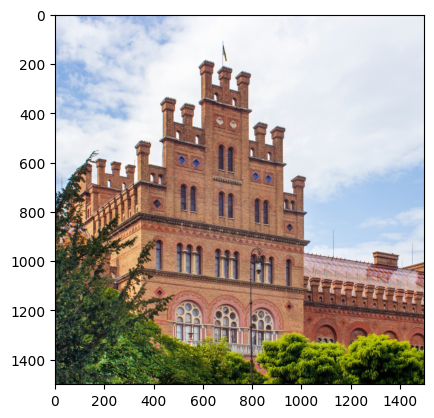

In [9]:
# Crop it to be a square image
square_image = image_tensor[..., 250:250+1500]

plt.imshow(square_image.permute(1, 2, 0))

In [10]:
# Path to the JSON segmentation masks file corresponding to `image_path`
seg_masks_json_path = 'images/sa_224452.json'

# Decode masks and convert to tensor
masks_tensor = decode_masks_from_json(seg_masks_json_path)

# First number in shape shows the number of segmentation masks Segment Anything
# (SAM) outputs for this image
masks_tensor.shape

torch.Size([87, 1500, 2250])

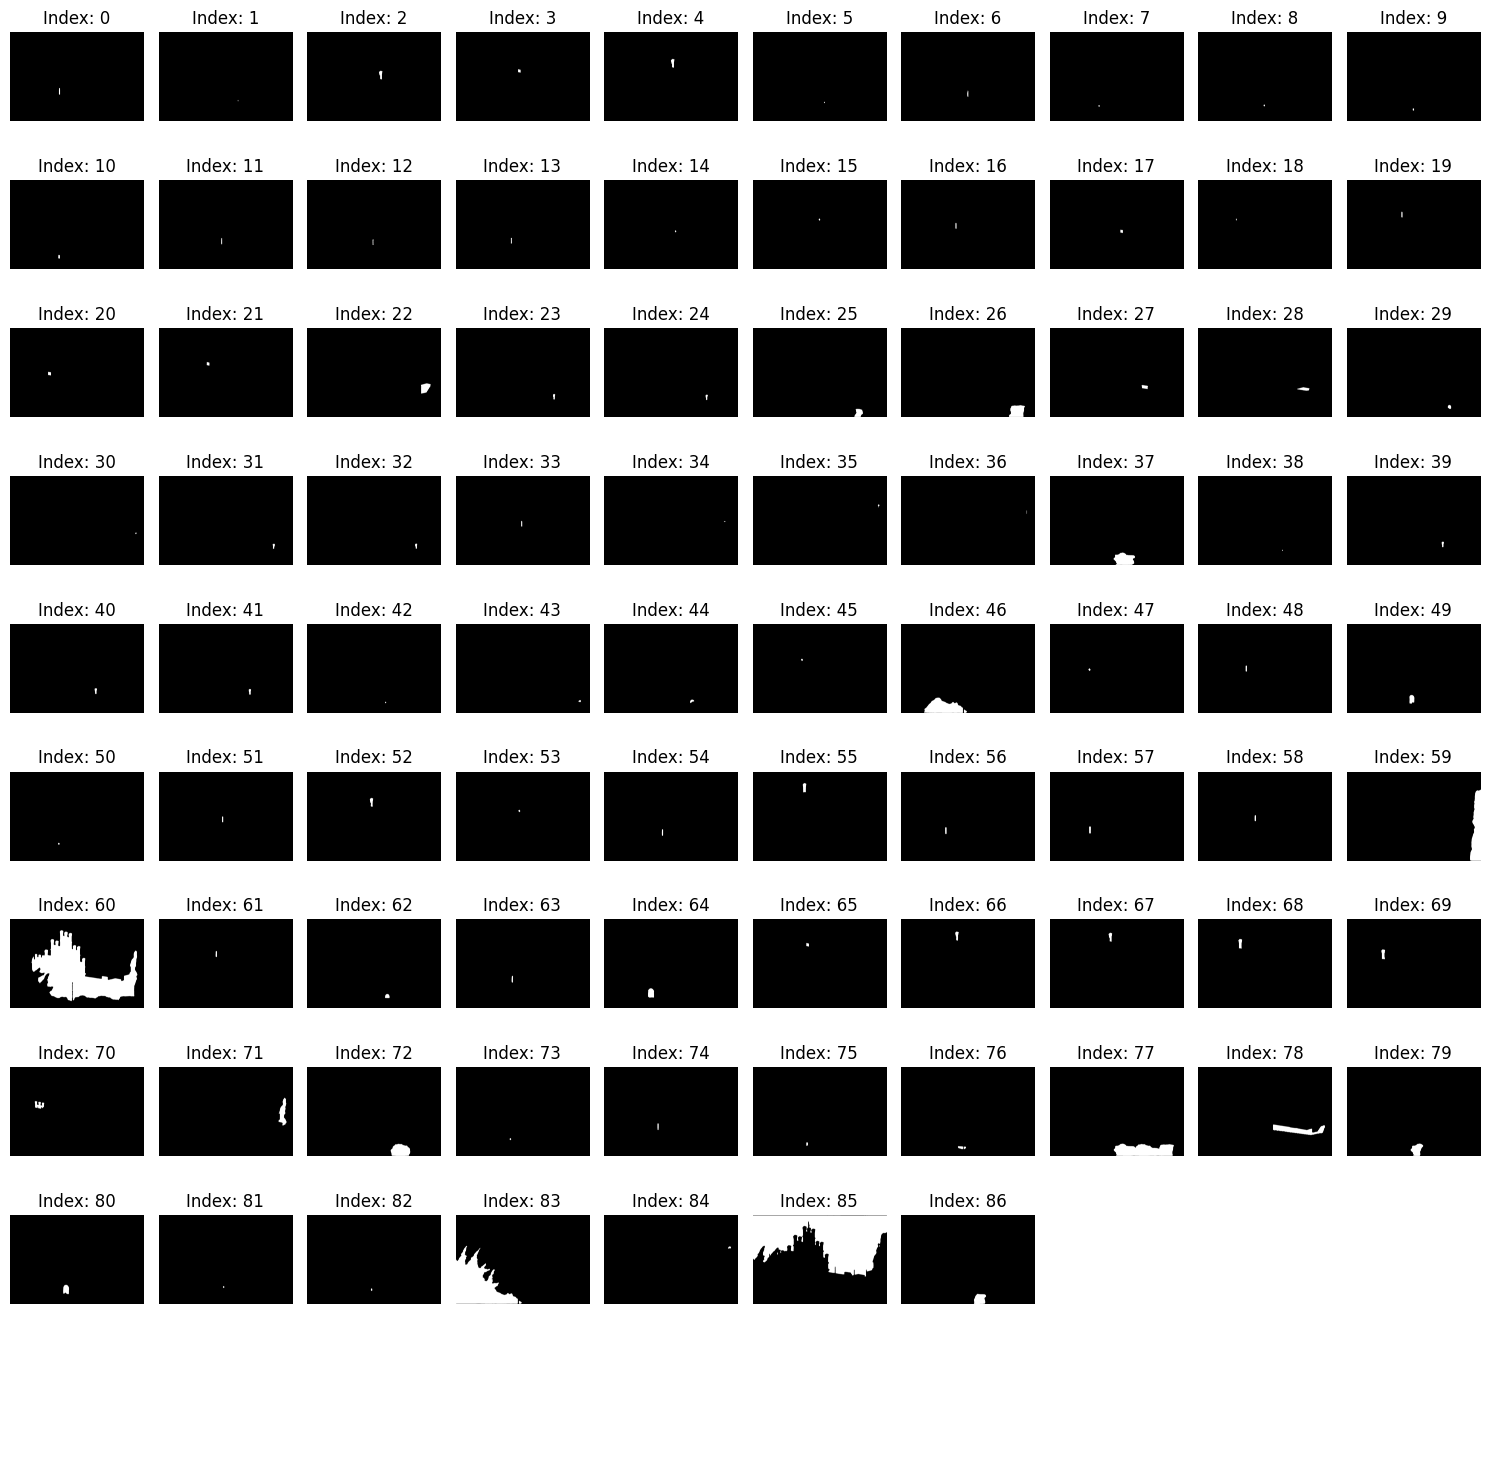

In [11]:
# Plot the grid of all segmentation masks
plot_masks_grid(masks_tensor)

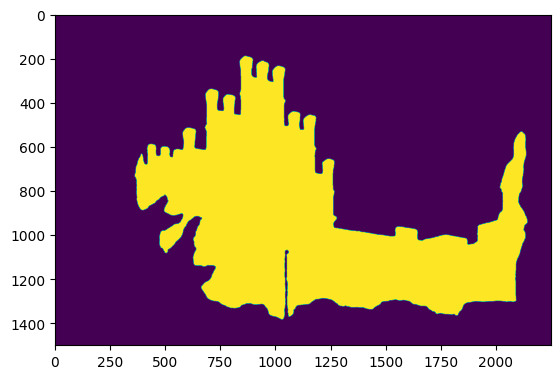

In [12]:
# Pick best segmentation mask
plt.imshow(masks_tensor[60])

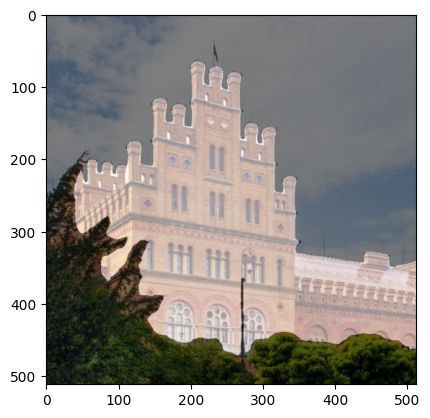

In [13]:
# Rescale image and segmentation mask to 512 x 512
image_512 = resize_image_tensor(square_image)
mask_512 = resize_image_tensor(masks_tensor[60, ..., 250:250+1500])

# Plot image with segmentation mask overlaid
plt.imshow(image_512.permute(1, 2, 0))
plt.imshow(mask_512, alpha=0.5, cmap='grey')

# Create dumb probe and run dumb experiment

This experiment is dumb and does not work. It trains a model to predict a ground truth binary segmentation map `gt` from a tensor of self-attention maps of various time steps but for a single resolution, i.e. `x` has shape `(n_timesteps, res**2, res, res)`.

The `SingleResolutionTimestepProbe` model learns only a single scalar per time step (i.e. the model has `n_timesteps` scalar parameters).

It computes a weighted sum of the time steps and picks only the channels (self-attention maps) corresponding to pixels for which the ground truth `gt` is 1, part of the salient object. This means, the `forward` function _"cheats"_ by using the ground truth to compute its output.

This leads to a solution that prefers high weights for the earliest time step, where each pixel's self-attention map is highly localised to just that pixel itself. Most of the weight is therefore put on the worst and least informative time step(s), which is why this experiment is dumb.

In [14]:
DEVICE = "cpu"

if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"

In [15]:
# Set working resolution for this experiment
res = 64

# Get ground truth segmentation mask at our working resolution
gt = resize_image_tensor(
    masks_tensor[60, ..., 250:250+1500],
    new_size=(res, res)
).to(DEVICE)

# Concatenate self-attention maps into tensor of shape
# (n_timesteps, res**2, res, res)
x = torch.empty(0, res**2, res, res)

for t, self_attn_maps in self_attn_dict.items():
    self_attn = torch.from_numpy(self_attn_maps[res].reshape(-1, res, res)).unsqueeze(0)
    x = torch.cat((x, self_attn), dim=0)

x = x.to(DEVICE)

# Create the dumb probe model
probe = DumbExperimentProbe(resolution=64, n_timesteps=n_timesteps).to(DEVICE)

# Define optimizer and loss function
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(probe.parameters(), lr=1e-2)

# Run training loop
n_epochs = 1
n_iters = 3000

for epoch in range(n_epochs):
    with tqdm(range(n_iters), unit="iteration") as tepoch:
        for _ in tepoch:
            # Clear gradients from the previous step
            optimizer.zero_grad()       
            
            # Forward pass
            output = probe(x, gt)
            loss = loss_function(output, gt)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update tqdm description with current loss
            tepoch.set_postfix(loss=loss.item())


# Move tensors back to CPU for visualisation
x = x.to('cpu')
gt = gt.to('cpu')
output = output.to('cpu').detach().numpy()

100%|██████████| 3000/3000 [01:57<00:00, 25.58iteration/s, loss=0.623]


# Visualise results

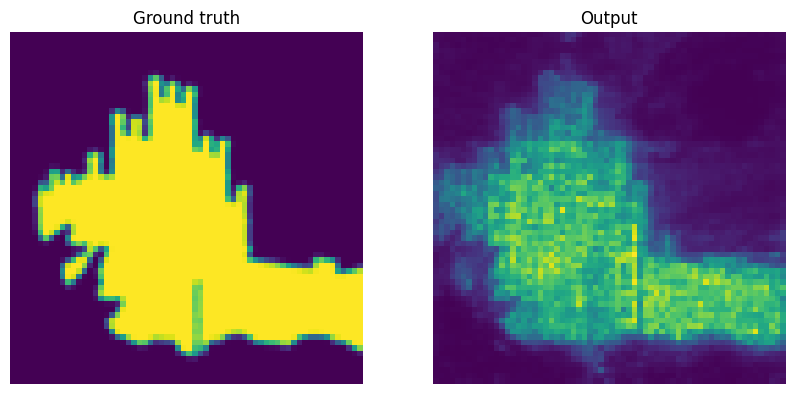

In [16]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(gt)
axs[0].axis('off')
axs[0].set_title(f'Ground truth')

axs[1].imshow(output)
axs[1].axis('off')
axs[1].set_title(f'Output');

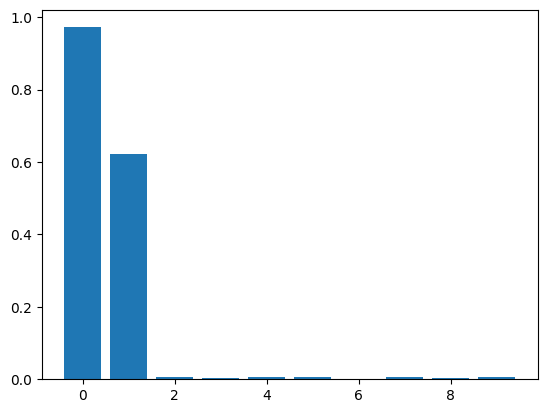

In [17]:
# Plot the resulting weight distribution of the trained model
weights_results = torch.nn.functional.sigmoid(list(probe.parameters())[0].data).tolist()

plt.bar(range(len(weights_results)), weights_results);

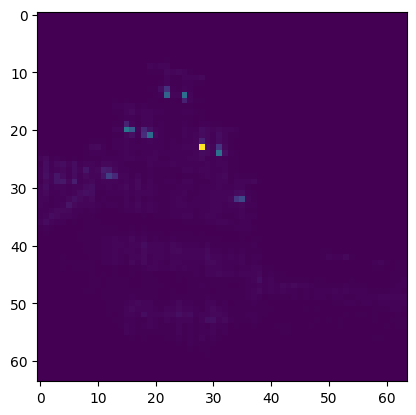

In [18]:
# Turns out that this just picks the "spottiest" and least informative time step
object_mask = (gt > 0.5).flatten()

x_filtered = x[4, 1500, ...]
plt.imshow(x_filtered)